In [40]:
import h5py
import numpy as np
from scipy.spatial.transform import Rotation as R


In [556]:
f = h5py.File("/Users/rahulmv/Desktop/Dominoes/pilot_dominoes_1mid_J025R45_o1full_tdwroom_0078.hdf5")

In [557]:
np.array(f['static']['target_id'])

array(2, dtype=int32)

In [584]:
f['static'].keys()

<KeysViewHDF5 ['bounciness', 'color', 'distractors', 'dynamic_friction', 'git_commit', 'initial_position', 'initial_rotation', 'mass', 'mesh', 'middle_objects', 'middle_type', 'model_names', 'object_ids', 'object_segmentation_colors', 'occluders', 'probe_id', 'probe_mass', 'probe_type', 'push_force', 'push_position', 'push_time', 'randomize', 'remove_middle', 'room', 'scale', 'scale_x', 'scale_y', 'scale_z', 'seed', 'static_friction', 'stimulus_name', 'target_id', 'target_rotation', 'target_type', 'trial_num', 'trial_seed', 'zone_id']>

In [559]:
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits import mplot3d 

def plot_box(pts, colors):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=100., azim=-90)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors)
#     plt.close(fig)
# plot_box(vertices_orig, colors=[[0, 0, 1]])

In [560]:
def get_transformed_pts(pts, frame, obj_id):
    frame = str(frame).zfill(4)
    
#     print(frame)
    
    rotations_0 = np.array(f['frames'][frame]['objects']['rotations'][obj_id])
    positions_0 = np.array(f['frames'][frame]['objects']['positions'][obj_id])
    
    rot = R.from_quat(rotations_0).as_matrix()
    trans = positions_0
    transformed_pts = np.matmul(rot, pts.T).T + np.expand_dims(trans, axis=0)
    
    return transformed_pts
    

In [561]:
object_ids = np.array(f['static']['object_ids'])

In [562]:
import colorsys 
 
def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (int(255*r), int(255*g), int(255*b)) 
 
def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return np.array(list((HSVToRGB(huePartition * value, .4, .5) for value in range(0, n))))/255.0


def get_vertices_scaled(obj_id):
    
    vertices_orig = np.array(f['static']['mesh']['vertices_' + str(obj_id)])

    scales = f["static"]["scale"][:]

    vertices_orig[:,0] *= scales[obj_id, 0]
    vertices_orig[:,1] *= scales[obj_id, 1]
    vertices_orig[:,2] *= scales[obj_id, 2]
    faces_orig = np.array(f['static']['mesh']['faces_' + str(obj_id)])
    
    return vertices_orig, faces_orig
        

In [585]:
colors = [[0, 1, 0], [1, 0, 0]]

colors += list(getDistinctColors(len(object_ids)-2))

In [586]:
#NOTE THE FIRST OBJECT IS ALWAYS THE PATIENT


frame_no = 150

all_pts = []
all_colors = []
for obj_id in object_ids:
    obj_id = obj_id-1
    
    vertices_orig, faces_orig = get_vertices_scaled(obj_id)
    frame_pts = get_transformed_pts(vertices_orig, frame_no, obj_id)
    cs = np.stack([colors[obj_id]]*len(frame_pts), 0)
    all_pts.append(frame_pts)
    all_colors.append(cs)
    
all_pts = np.concatenate(all_pts, 0)
all_colors = np.concatenate(all_colors, 0)

# frame_50_pts = get_transformed_pts(vertices_orig, 150, obj_id)

<IPython.core.display.Javascript object>


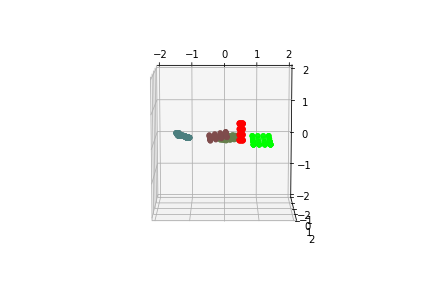

In [589]:
plot_box(all_pts, all_colors)

In [569]:
plot_box(frame_50_pts)

TypeError: plot_box() missing 1 required positional argument: 'colors'

<IPython.core.display.Javascript object>


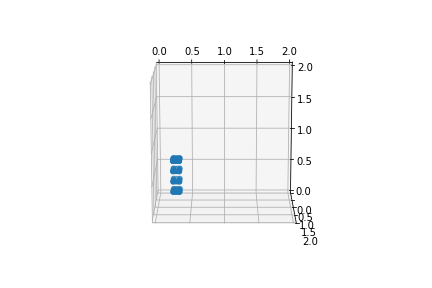

In [363]:
plot_box(frame_1_pts)